# Variational Autoencoders - Fashion-MNIST
Variational autoencoders (VAEs) are probabilistic generative models that extend traditional autoencoders by introducing a probabilistic approach to the encoding and decoding process. They consist of an encoder, a decoder, and a loss function, and are used to learn meaningful representations of data and generate new data points. VAEs have applications in various fields such as image generation, anomaly detection, and natural language processing


<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/a1.2.png" width=800>

## Autoencoder:
**Objective:**

- Autoencoders are primarily designed for data compression and reconstruction.

- The goal is to learn a compact representation (latent space) of the input data.

**Architecture:**

- Comprises an encoder and a decoder.

- Encoder maps the input data to a latent space representation.
- Decoder reconstructs the original input from the latent space.

**Latent Space:**

- The latent space is a fixed and deterministic representation.
- The encoder directly maps input data to a fixed point in the latent space.

### Variational Autoencoder (VAE):
**Objective:**

- VAEs are designed for generative modeling and sampling from a probabilistic latent space.
- The goal is to learn a probability distribution over the latent space.

**Architecture:**

- Also comprises an encoder and a decoder.
- Encoder maps input data to a probability distribution (mean and variance) in the latent space.
- The reparameterization trick is used to sample from this distribution.
- Decoder reconstructs the input from the sampled point in the latent space.

**Latent Space:**

- The latent space is probabilistic.
- VAEs introduce a stochastic element in the form of a sampling step during training and generation.


<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/a1.5.png" width=800>

## Differences:
**Probabilistic Latent Space:**

- VAEs introduce a probabilistic aspect to the latent space by modeling it as a probability distribution. This allows for sampling from the distribution during both training and generation.
Generative Modeling:

- VAEs are explicitly designed for generative modeling. They can generate new samples by sampling from the learned latent space distribution.
Reparameterization Trick:

- VAEs use the reparameterization trick during training, separating the deterministic and stochastic parts of the model. This enables efficient backpropagation through the sampling operation.
Regularization Effect:

- VAEs inherently include a regularization term (KL divergence) in their loss function, which encourages the learned latent space to be close to a unit Gaussian. This regularization encourages a more structured and smooth latent space.

In summary, while autoencoders focus on compression and deterministic latent spaces, VAEs extend this concept to generative modeling with a probabilistic and structured latent space. The introduction of probabilistic elements allows VAEs to generate new, diverse samples from the learned distribution.

In [2]:
import tensorflow as tf

tf.__version__

'2.15.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#import tensorflow.keras.backend as K
from tensorflow.keras import layers,models,datasets,callbacks,losses,optimizers,metrics
from scipy.stats import norm

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/nlp/a1.6.png" width=800>

In [1]:
# Define class labels
class_labels = {
                0: "T-shirt/top",
                1: "Trouser",
                2: "Pullover",
                3: "Dress",
                4: "Coat",
                5: "Sandal",
                6: "Shirt",
                7: "Sneaker",
                8: "Bag",
                9: "Ankle boot"
                }

def display(images, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")
    plt.show()

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


In [4]:
# Load the data
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()
X_train = preprocess(X_train)
X_test = preprocess(X_test)

4422102/4422102 [==============================] - 1s 0us/step


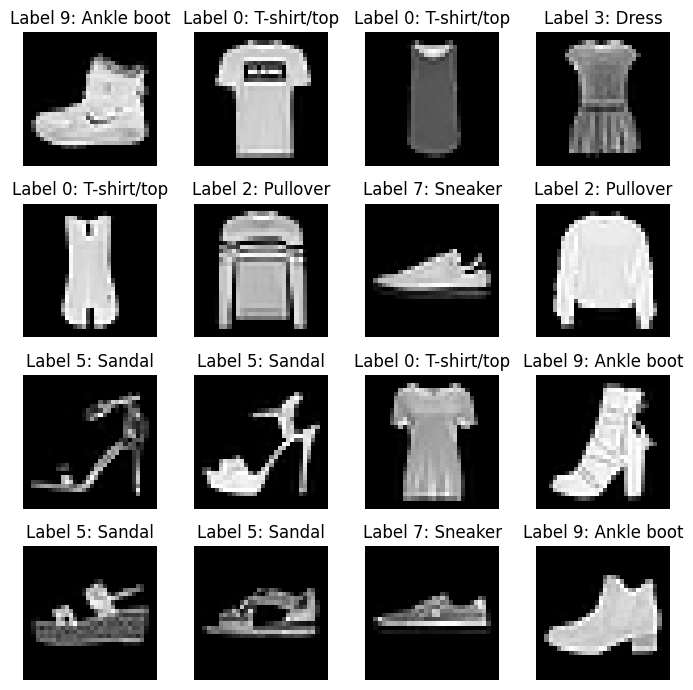

In [5]:
# Display the first 10 images in a 4x4 grid
plt.figure(figsize=(7, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label {y_train[i]}: {class_labels[y_train[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## 2. Build the variational autoencoder <a name="build"></a>

In [6]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 50
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 10
BETA = 500

In [7]:
# Set random seed for reproducibility
np.random.seed(667)
tf.random.set_seed(667)

Sampling Layer: A custom layer (Sampling()) is used to sample from the learned distribution defined by z_mean and z_log_var. This introduces randomness into the latent space.


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model

# Encoder
encoder = Sequential(name="encoder")

encoder.add(InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))  # Update the input shape here
encoder.add(Conv2D(32, (3, 3), strides=2, activation="relu", padding="same"))
encoder.add(Conv2D(64, (3, 3), strides=2, activation="relu", padding="same"))
encoder.add(Conv2D(128, (3, 3), strides=2, activation="relu", padding="same"))
shape_before_flattening = encoder.output_shape[1:]
encoder.add(Flatten())
encoder.add(Dense(EMBEDDING_DIM, name="encoder_output"))
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 encoder_output (Dense)      (None, 2)                 4098      
                                                                 
Total params: 96770 (378.01 KB)
Trainable params: 96770 (378.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/dcgan11.png" width=1000>

- Conv2D applies Convolutional operation on the input. On the contrary, Conv2DTranspose applies a Deconvolutional operation on the input.

- Conv2D is mainly used when you want to detect features, e.g., in the encoder part of an autoencoder model, and it may shrink your input shape.
Conversely, Conv2DTranspose is used for creating features, for example, in the decoder part of an autoencoder model for constructing an image. As you can see in the code below, it makes the input shape larger.

<img src= "https://frenzy86.s3.eu-west-2.amazonaws.com/python/az1.png" width=1000>

In [9]:
# Decoder
decoder = Sequential(name="decoder")

decoder.add(InputLayer(input_shape=(EMBEDDING_DIM,)))
decoder.add(Dense(tf.reduce_prod(shape_before_flattening)))
decoder.add(Reshape(shape_before_flattening))
decoder.add(Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
decoder.add(Conv2D(CHANNELS, (3, 3), strides=1, activation="sigmoid", padding="same", name="decoder_output"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 128)         147584    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 64)        73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 32, 32, 32)        18464     
 Transpose)                                                      
                                                           

In [10]:
# Create the VAE model
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [11]:
# Sampling layer
z_mean = Dense(EMBEDDING_DIM, name="z_mean")(encoder.output)
z_log_var = Dense(EMBEDDING_DIM, name="z_log_var")(encoder.output)
z = Sampling()([z_mean, z_log_var])

# Combine encoder and decoder
vae = Model(inputs=encoder.input, outputs=decoder(z))
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 8, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 4, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                              

## 3. Train the variational autoencoder <a name="train"></a>

In [14]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer,loss='mse')

In [12]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
                                                    filepath="./checkpoint",
                                                    save_weights_only=False,
                                                    save_freq="epoch",
                                                    monitor="loss",
                                                    mode="min",
                                                    save_best_only=True,
                                                    verbose=0,
                                                    )
#tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [15]:
vae.fit(X_train,
        X_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_data=(X_test, X_test),
        callbacks=[model_checkpoint_callback],
        #callbacks=[model_checkpoint_callback, tensorboard_callback],
        )

Epoch 1/10
1200/1200 [==============================] - 16s 7ms/step - loss: 0.0405 - val_loss: 0.0276
Epoch 2/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.0261 - val_loss: 0.0247
Epoch 3/10
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0242 - val_loss: 0.0237
Epoch 4/10
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0234 - val_loss: 0.0232
Epoch 5/10
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0229 - val_loss: 0.0226
Epoch 6/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.0225 - val_loss: 0.0224
Epoch 7/10
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0222 - val_loss: 0.0221
Epoch 8/10
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0219 - val_loss: 0.0219
Epoch 9/10
1200/1200 [==============================] - 8s 7ms/step - loss: 0.0217 - val_loss: 0.0218
Epoch 10/10
1200/1200 [==============================] - 9s 7ms/step - loss: 0.02

In [16]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [17]:
# Select a subset of the test set
n_to_predict = 5000
example_images = X_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 3ms/step
Example real clothing items


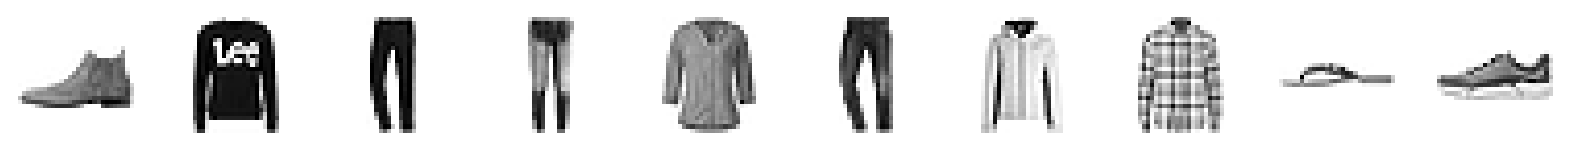

Reconstructions


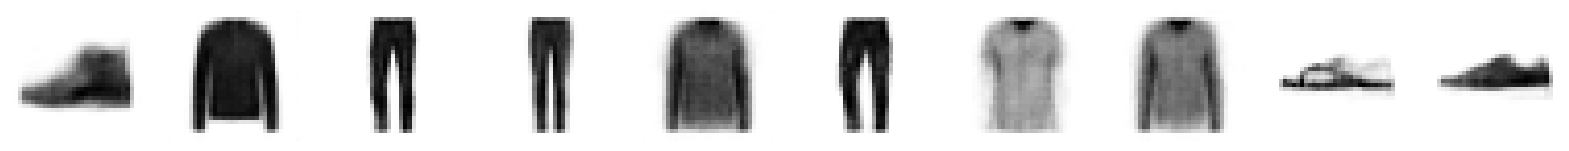

In [18]:
# Create autoencoder predictions and display
reconstructions = vae.predict(example_images)
print("Example real clothing items")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Embed using the encoder <a name="encode"></a>

In [19]:
# Encode the example image
z = encoder.predict(example_images)

157/157 [==============================] - 0s 1ms/step


In [20]:
# Some examples of the embeddings
print(z[:10])

[[  0.6923828 -10.56318  ]
 [  4.4187217  -1.3790723]
 [ 29.302954  -21.315254 ]
 [ 22.52049   -21.366812 ]
 [  5.149136   -4.4229302]
 [ 24.075125  -14.6908245]
 [  8.477702  -13.190494 ]
 [  6.309855   -8.567641 ]
 [ -5.1379757 -28.138506 ]
 [ -9.634571  -17.254038 ]]


In [21]:
import plotly.express as px
import numpy as np

figsize = 8
fig = px.scatter(
                x=z[:, 0],
                y=z[:, 1],
                opacity=0.5,
                color_discrete_sequence=['black'],  # Set color to black
                title='Encoded Points in 2D Space'
                )
fig.update_traces(marker=dict(size=6))  # Set marker size to 3
fig.update_layout(width=800)
fig.update_layout(height=800)
fig.show()

## 5. Generate using the decoder <a name="decode"></a>

In [22]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (6, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, 2))

In [23]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 280ms/step


In [24]:
# Convert original embeddings and sampled embeddings to p-values
p = norm.cdf(z)
p_sample = norm.cdf(z_sample)

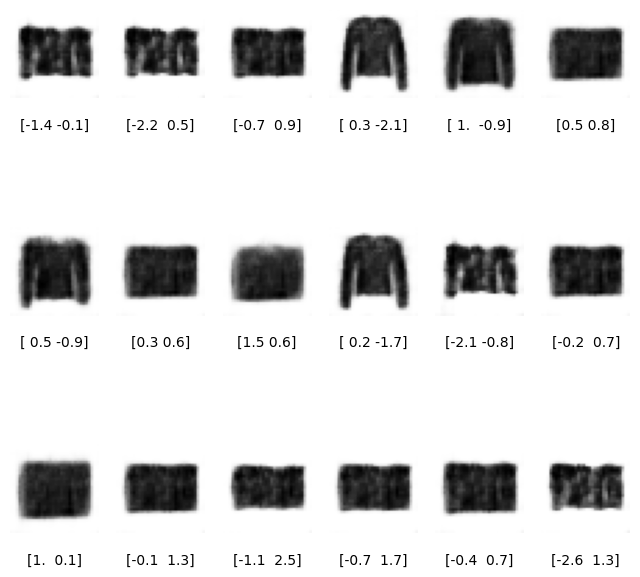

In [25]:
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# Assuming 'embeddings' and 'sample' are your data
figsize = 8

# Scatter plot for original embeddings
fig = px.scatter(
                x=z[:, 0],
                y=z[:, 1],
                opacity=0.5,
                color_discrete_sequence=['black'],  # Set color to black
                title='Original Embeddings'
                )
# Scatter plot for newly generated points in the latent space
fig.add_trace(px.scatter(
                        x=z_sample[:, 0],
                        y=z_sample[:, 1],
                        opacity=1,
                        size_max=40,
                        color_discrete_sequence=['#00B0F0'],  # Set color to blue
                        title='Generated Points in Latent Space'
                        ).data[0])

# Set the width of the plot
fig.update_layout(width=800)
fig.update_layout(height=800)

# Add text annotations for the numerical values on blue points
for i, point in enumerate(z_sample):
    fig.add_annotation(
        go.layout.Annotation(
            x=point[0],
            y=point[1],
            text=str(i+1),  # Assuming you want to display point index
            showarrow=False,
            font=dict(color='black', size=12),
            xshift=5,  # Adjust the text position
            yshift=5   # Adjust the text position
        )
    )

fig.show()

fig = plt.figure(figsize=(figsize, figsize))
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(z_sample[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

## 6. The latent space of the VAE colored by clothing type

In [26]:
## Map the Classes number's to Clothing Type
def map_numerical_to_labels(numerical_array, labels_dict):
    return [labels_dict[num] for num in numerical_array]

mapped_labels = np.array(map_numerical_to_labels(example_labels, class_labels))
mapped_labels

array(['Ankle boot', 'Pullover', 'Trouser', ..., 'Ankle boot',
       'T-shirt/top', 'Sneaker'], dtype='<U11')

In [27]:
from matplotlib.colors import to_rgba

figsize = 12
grid_size = 15

num_labels = len(np.unique(example_labels))
cmap = plt.get_cmap("rainbow")
colors = [to_rgba(cmap(i / num_labels)) for i in range(num_labels)]
# Convert RGBA to Hex for Plotly
hex_colors = [f"rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, {c[3]})" for c in colors]

# Create Plotly Express scatter plot
scatter_fig = px.scatter(
                        x=z[:, 0],
                        y=z[:, 1],
                        color=mapped_labels,
                        opacity=0.8,
                        size_max=300,
                        labels={'color': 'Clothing Type'},
                        title='Latent Space',
                        color_discrete_map=dict(zip(np.unique(mapped_labels), hex_colors))
                    )

# Set the width of the plot
scatter_fig.update_layout(width=800)
scatter_fig.update_layout(height=800)
scatter_fig.show()

In [28]:
figsize = 12
grid_size = 15

num_labels = len(np.unique(example_labels))
cmap = plt.get_cmap("rainbow")
colors = [to_rgba(cmap(i / num_labels)) for i in range(num_labels)]
# Convert RGBA to Hex for Plotly
hex_colors = [f"rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, {c[3]})" for c in colors]

# Create Plotly Express scatter plot
scatter_fig = px.scatter(
                        x=p[:, 0],
                        y=p[:, 1],
                        color=mapped_labels,
                        opacity=0.8,
                        size_max=300,
                        labels={'color': 'Clothing Type'},
                        title='Latent Space Normalized',
                        color_discrete_map=dict(zip(np.unique(mapped_labels), hex_colors))
                    )

# Set the width of the plot
scatter_fig.update_layout(width=800)
scatter_fig.update_layout(height=800)
scatter_fig.show()

8/8 [==============================] - 0s 20ms/step


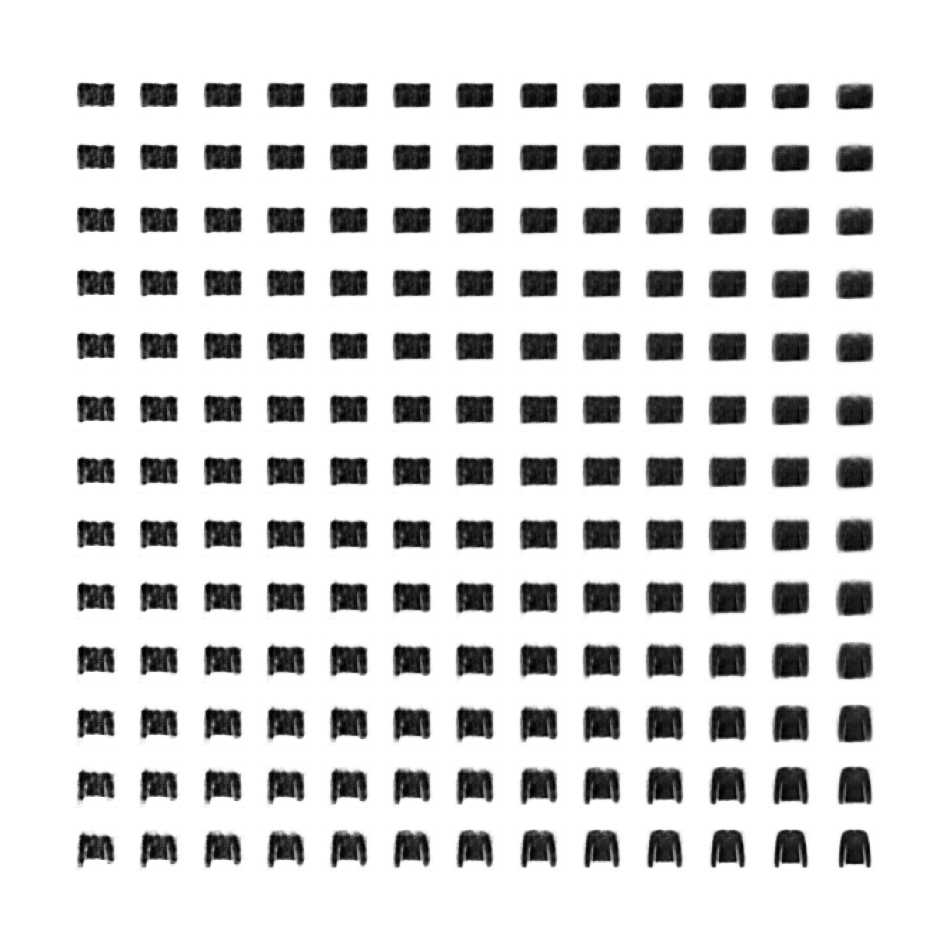

In [29]:
import plotly.express as px
import numpy as np
from matplotlib.colors import to_rgba

figsize = 12
grid_size = 15

num_labels = len(np.unique(example_labels))
cmap = plt.get_cmap("rainbow")
colors = [to_rgba(cmap(i / num_labels)) for i in range(num_labels)]
# Convert RGBA to Hex for Plotly
hex_colors = [f"rgba({int(c[0]*255)}, {int(c[1]*255)}, {int(c[2]*255)}, {c[3]})" for c in colors]

# Create Plotly Express scatter plot
scatter_fig = px.scatter(
                        x=p[:, 0],
                        y=p[:, 1],
                        color=mapped_labels,
                        opacity=0.8,
                        size_max=300,
                        labels={'color': 'Clothing Type'},
                        title='Embeddings Visualization',
                        color_discrete_map=dict(zip(np.unique(mapped_labels), hex_colors))
                    )

# Set the width of the plot
scatter_fig.update_layout(width=800)
scatter_fig.update_layout(height=800)
scatter_fig.show()
################################################################################
x = norm.ppf(np.linspace(0, 1, grid_size))
y = norm.ppf(np.linspace(1, 0, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
# plt.scatter(grid[:, 0], grid[:, 1], c="black", alpha=1, s=10)
plt.show()

fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")